In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from skimage import io
import seaborn as sns

from microscopy import utils 

import omegaconf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def translate_yaml(yaml_path):

    confg = omegaconf.OmegaConf.load(yaml_path)

    result = {}

    for e in confg:
        print(e)

'''
def translate_yaml(yaml_path):
    yaml_data = utils.load_yaml(yaml_path)

    dataset_config = yaml_data.pop('dataset')
    model_config = yaml_data.pop('model')
    optim_config = yaml_data.pop('optim_config')
    other_config = yaml_data.pop('other_config')

    dataset_config.pop('data_paths')

    yaml_data['data_augmentation'] = ''.join([e[0] for e in yaml_data['data_augmentation']])
    yaml_data['input_data_shape'] = '_'.join([str(e) for e in yaml_data['input_data_shape']])
    yaml_data['output_data_shape'] = '_'.join([str(e) for e in yaml_data['output_data_shape']])
    yaml_data['test_metric_indexes'] = '_'.join([str(e) for e in yaml_data['test_metric_indexes']])

    yaml_data.update(dataset_config)
    yaml_data.update(model_config)
    # yaml_data.update(optim_config)
    yaml_data.update(other_config)

    return yaml_data
'''

def load_test_results(test_metrics_path):
    metric_dict= {}
    
    for metric in os.listdir(test_metrics_path):
        metric_name = metric[:-4]
        metric_data = np.load(os.path.join(test_metrics_path, metric))
        metric_dict[f'{metric_name}_mean'] = np.mean(metric_data) if len(metric_data) > 0 else 0
        metric_dict[f'{metric_name}_std'] = np.std(metric_data) if len(metric_data) > 0 else 0
    return metric_dict
        

def sorted_imgs_by_epoch(filename_list):
    epochs = [int(e[:-4]) for e in filename_list]
    return [f'{e}.png' for e in sorted(epochs)]

2023-06-14 14:04:59.118290: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/ihidalgo/miniconda3/envs/prueba/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ihidalgo/miniconda3/envs/prueba/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth
2.4.1


In [16]:

hydra_conf = omegaconf.OmegaConf.load('/data/ihidalgo/MicroscoPy/results/F-actin/unet/scaleNone/epc100_btch16_lr0.001_optim-adam_lrsched-OneCycle_seed666/train_configuration.yaml')
print(hydra_conf)
hydra_dict = omegaconf.OmegaConf.to_container(hydra_conf)
print(hydra_dict)

{'dataset': {'EM': {'crappifier': 'em_poisson_crappify', 'data_paths': [None, 'train', None, None, None, 'test'], 'patch_size_x': 64, 'patch_size_y': 64, 'scale': 4}, 'ER': {'crappifier': 'downsampleonly', 'data_paths': ['train/training_wf', 'train/training_gt', 'val/validate_wf', 'val/validate_gt', 'test/test_wf/level_01', 'test/test_gt/level_06'], 'patch_size_x': 64, 'patch_size_y': 64, 'scale': None}, 'F-actin': {'crappifier': 'downsampleonly', 'data_paths': ['train/training_wf', 'train/training_gt', 'val/validate_wf', 'val/validate_gt', 'test/test_wf/level_01', 'test/test_gt'], 'patch_size_x': 64, 'patch_size_y': 64, 'scale': None}, 'LiveFActinDataset': {'crappifier': 'downsampleonly', 'data_paths': ['train_split/wf', 'train_split/gt', 'val_split/wf', 'val_split/gt', 'test_split/wf', 'test_split/gt'], 'patch_size_x': 128, 'patch_size_y': 128, 'scale': None}, 'MT': {'crappifier': 'downsampleonly', 'data_paths': ['train/training_wf', 'train/training_gt', 'val/validate_wf', 'val/valid

In [4]:
results_path = os.path.abspath('results')

if not os.path.exists(results_path):
    raise ValueError('There is no results folder.')

dataset_list = os.listdir(results_path)
dataset_path_list = [os.path.join(results_path, e) for e in os.listdir(results_path)]

all_results = {}

for dataset, dataset_path in zip(dataset_list, dataset_path_list):
    model_list = os.listdir(dataset_path)
    model_path_list = [os.path.join(dataset_path, e) for e in os.listdir(dataset_path)]
    for model, model_path in zip(model_list, model_path_list):
        additfolder_list = os.listdir(model_path)
        additfolder_path_list = [os.path.join(model_path, e) for e in os.listdir(model_path)]
        cont = 0
        for additfolder, additfolder_path in zip(additfolder_list, additfolder_path_list):
            config_list = os.listdir(additfolder_path)
            config_path_list = [os.path.join(additfolder_path, e) for e in os.listdir(additfolder_path)]
            for config, config_path in zip(config_list, config_path_list):
                yaml_path = os.path.join(config_path, 'train_configuration.yaml')
                test_metrics_path = os.path.join(config_path, 'test_metrics')
                
                if os.path.exists(yaml_path) and os.path.exists(test_metrics_path):
                    # hydra_conf = omegaconf.OmegaConf.load('/data/ihidalgo/MicroscoPy/conf/config.yaml')
                    # hydra_dict = omegaconf.OmegaConf.to_container(hydra_conf, resolve=True)

                    # yaml_data.update(load_test_results(test_metrics_path))
                    # yaml_data.update({'config_path': config_path})
                    hydra_conf = translate_yaml(yaml_path)
                    hydra_conf.pop('dataset')
                    all_results[f'{model}_{dataset}_{cont}'] = hydra_conf

                    cont += 1


dataset
model
hyperparam
model.optim.early_stop.patience
dataset_name
model_name
used_dataset
used_model
used_optim
actual_scale_factor
input_data_shape
output_data_shape


AttributeError: 'NoneType' object has no attribute 'pop'

In [23]:
df = pd.DataFrame(all_results).T
df.head()

,0,1,2,3,4,5,6,7,8,9,10
unet_ER_0,model,hyperparam,model.optim.early_stop.patience,dataset_name,model_name,used_dataset,used_model,used_optim,actual_scale_factor,input_data_shape,output_data_shape
unet_F-actin_0,model,hyperparam,model.optim.early_stop.patience,dataset_name,model_name,used_dataset,used_model,used_optim,actual_scale_factor,input_data_shape,output_data_shape


In [18]:
# All possible configurations (not showing columns with single repeated value)
visualize_df = df.copy()
nunique = visualize_df.nunique()
cols_to_drop = nunique[nunique == 1].index
visualize_df.drop(cols_to_drop, axis=1)


NameError: name 'df' is not defined

# Analyze a single configuration

In [59]:
select_config = 'wgan_LiveFActinDataset_7'
config_df = df.loc[select_config]

train_metrics_path = os.path.join(config_df['config_path'], 'train_metrics')
train_images_path = os.path.join(config_df['config_path'], 'training_images')
test_metrics_path = os.path.join(config_df['config_path'], 'test_metrics')
predicted_images_path = os.path.join(config_df['config_path'], 'predicted_images')

print(config_df)

actual_scale_factor                                                             1
batch_size                                                                      4
data_augmentation                                                             rhv
datagen_sampling_pdf                                                            0
dataset_name                                                    LiveFActinDataset
discriminator_learning_rate                                                0.0005
discriminator_lr_scheduler                                               OneCycle
discriminator_optimizer                                                      Adam
input_data_shape                                                    753_128_128_1
learning_rate                                                              0.0005
model                                                                        wgan
number_of_epochs                                                              100
optimizer       

### Visualization of the training information

In [60]:
for f in sorted_imgs_by_epoch(os.listdir(train_images_path)):
    img_path = os.path.join(train_images_path, f)

    plt.figure(figsize=(15,5))
    plt.imshow(io.imread(img_path))
    plt.title(f[:-4] + ' epochs')
    plt.axis('off')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/ihidalgo/MicroscoPy/results/LiveFActinDataset/wgan/scaleNone_visualization/scaleNone_epc100_btch4_lr0.0005_optim-Adam_lrsched-OneCycle_seed666/training_images'

In [61]:
[e for e in os.listdir(train_metrics_path) if 'epoch' in e]

['g_adv_loss_epoch.npy',
 'g_l1_epoch.npy',
 'g_loss_epoch.npy',
 'd_loss_epoch.npy',
 'epoch.npy',
 'd_fake_epoch.npy',
 'd_real_epoch.npy',
 'd_wasserstein_epoch.npy',
 'd_gp_epoch.npy']

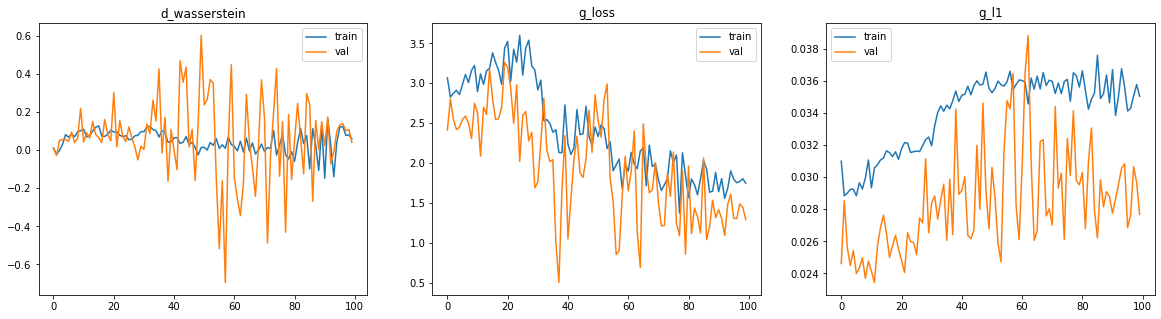

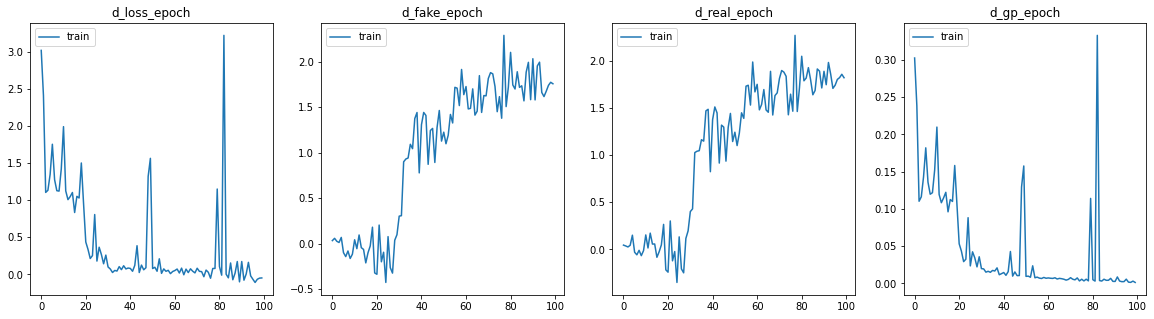

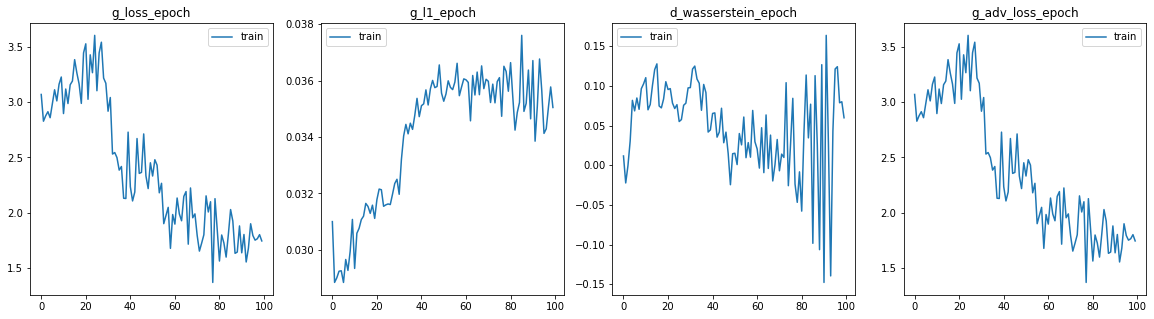

In [62]:

if config_df.model == 'wgan':
    metric_list = ['d_wasserstein', 'g_loss', 'g_l1']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}_epoch.npy'))
        val_loss = np.load(os.path.join(train_metrics_path, f'val_{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        sns.lineplot(x=np.arange(len(val_loss)), y=val_loss, label='val')
        plt.title(metric)
    plt.show()


    metric_list = ['d_loss_epoch', 'd_fake_epoch', 'd_real_epoch', 'd_gp_epoch']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        plt.title(metric)
    plt.show()

    metric_list = ['g_loss_epoch', 'g_l1_epoch', 'd_wasserstein_epoch', 'g_adv_loss_epoch']
    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        plt.title(metric)
    plt.show()

else:
    metric_list = ['loss', 'mean_squared_error', 'ssim_loss']

    plt.figure(figsize=(20,5))
    for i, metric in enumerate(metric_list):
        loss = np.load(os.path.join(train_metrics_path, f'{metric}.npy'))
        val_loss = np.load(os.path.join(train_metrics_path, f'val_{metric}.npy'))

        plt.subplot(1,len(metric_list), i+1)
        sns.lineplot(x=np.arange(len(loss)), y=loss, label='train')
        sns.lineplot(x=np.arange(len(val_loss)), y=val_loss, label='val')
        plt.title(metric)

    plt.show()


### Visualization of the testing information

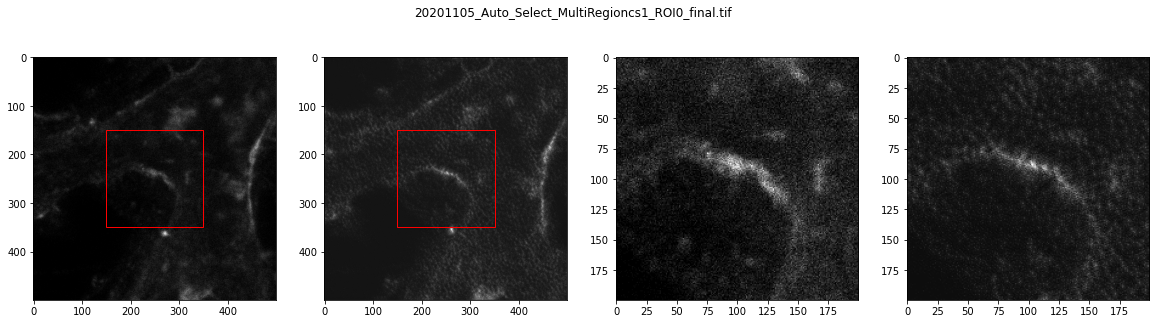

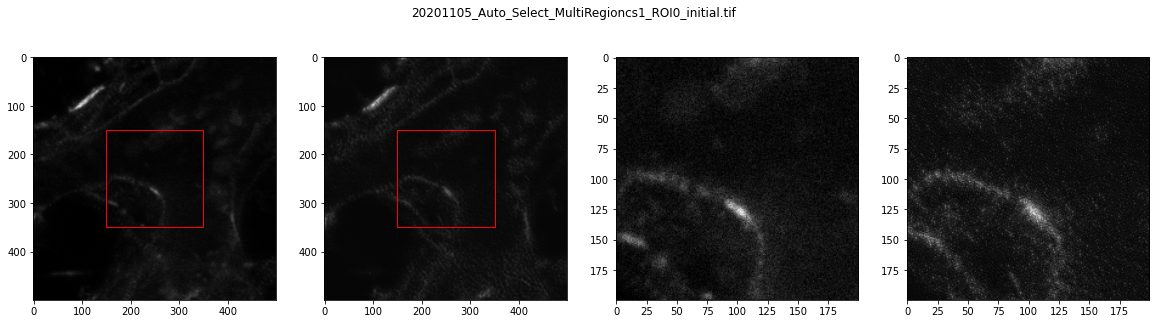

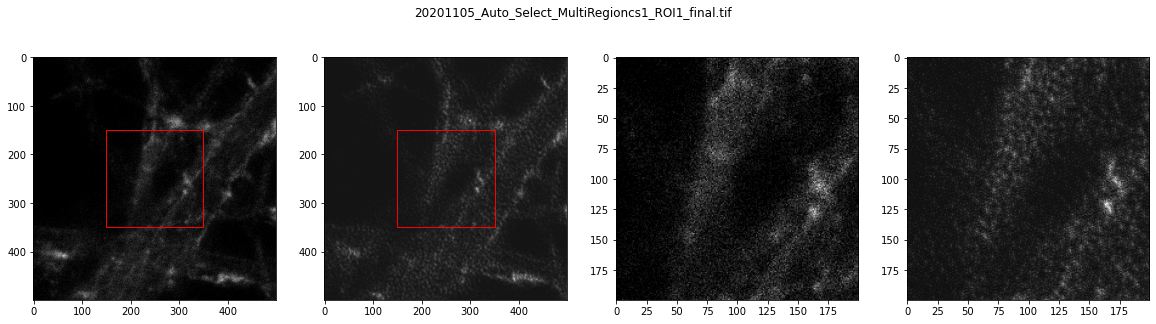

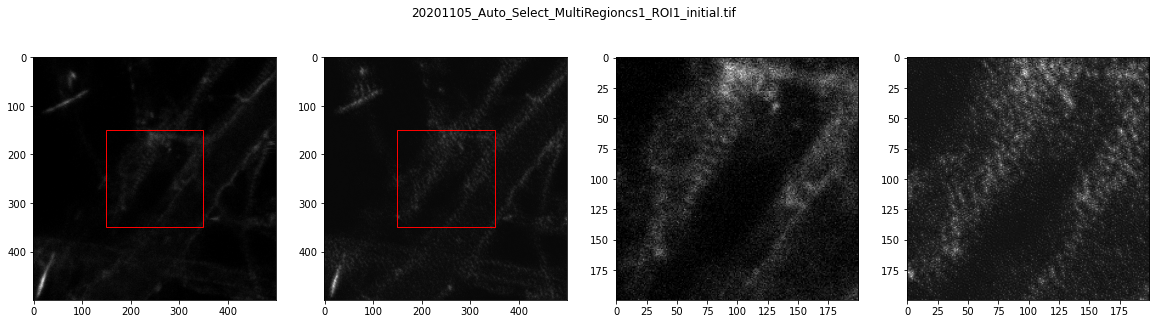

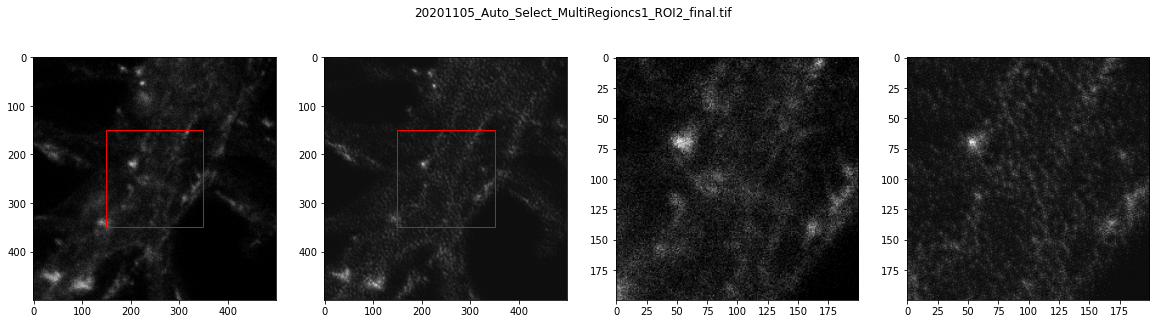

In [63]:
zoom_size = 100
center_point = None

dataset_config = utils.load_yaml('./conf/dataset/default.yaml')
dataset_root = 'datasets' if os.path.exists('datasets') else '../datasets'
dataset_name = config_df['dataset_name']
train_lr, train_hr, val_lr, val_hr, test_lr, test_hr = dataset_config[dataset_name]['data_paths']
test_lr_path = os.path.join(dataset_root, dataset_name, test_lr) if test_lr is not None else None
test_hr_path = os.path.join(dataset_root, dataset_name, test_hr) if test_hr is not None else None

for f in sorted(os.listdir(predicted_images_path))[:5]:
    img_path = os.path.join(predicted_images_path, f)
    gt_img_path = os.path.join(test_hr_path, f)

    img = io.imread(img_path)
    gt_img = io.imread(gt_img_path)

    plt.figure(figsize=(20,5))

    gt_center_point = center_point if center_point is not None else (gt_img.shape[0]//2), (gt_img.shape[1]//2)

    plt.subplot(1,4,1)
    plt.imshow(gt_img, 'gray')
    ax = plt.gca()
    ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(1,4,2)
    plt.imshow(img, 'gray')
    ax = plt.gca()
    ax.add_patch(Rectangle((gt_center_point[0]-zoom_size, gt_center_point[1]-zoom_size),zoom_size*2,zoom_size*2,
                            linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(1,4,3)
    plt.imshow(gt_img[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                      gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
    plt.subplot(1,4,4)
    plt.imshow(img[gt_center_point[0]-zoom_size:gt_center_point[0]+zoom_size,
                      gt_center_point[1]-zoom_size:gt_center_point[1]+zoom_size], 'gray')
    plt.suptitle(f)
    plt.show()

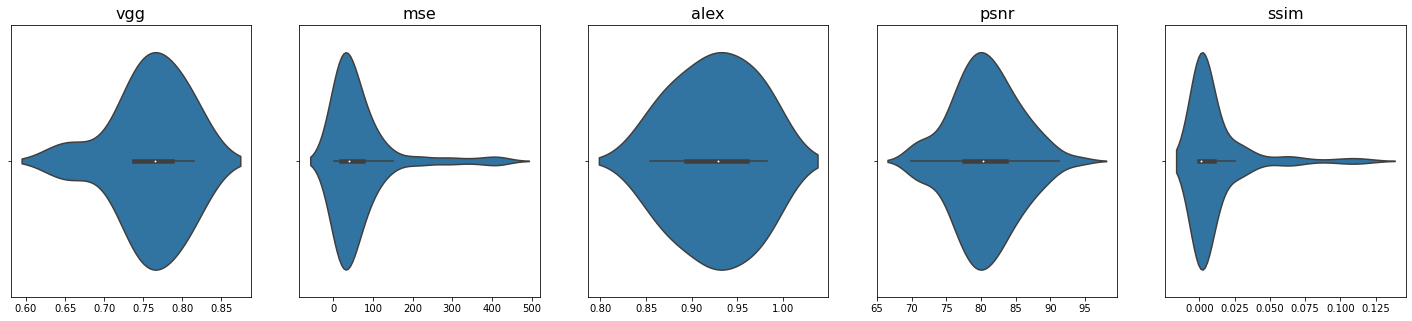

In [64]:
metric_list = [e[:-4] for e in os.listdir(test_metrics_path)]

plt.figure(figsize=(5*len(metric_list),5))
for i, metric in enumerate(metric_list):
    loss = np.load(os.path.join(test_metrics_path, f'{metric}.npy'))

    plt.subplot(1,len(metric_list), i+1)
    sns.violinplot(loss, label='train')
    plt.title(metric, fontsize=16)

plt.show()

# Analyze a group of configurations

In [51]:
filtered_df = df.copy()

desired_dataset = 'LiveFActinDataset' #'EM', 'MitoTracker_small', 'F-actin', 'ER', 'MT', 'MT-SMLM_all']
desired_learning_rate = None # 0.001

if desired_dataset is not None:
    filtered_df = filtered_df[filtered_df['dataset_name'] == desired_dataset]

if desired_learning_rate is not None:
filtered_df = filtered_df[filtered_df['learning_rate'] == desired_learning_rate]



filtered_df.head()


SyntaxError: invalid syntax (3855529495.py, line 9)